In [1]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
from graphviz import Digraph


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out 
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def tanh (self) :
        
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self) :
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad # ??? exercise :)
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += (other) * self.data ** (other - 1) * out.grad 
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [4]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges 

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node (name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect ni to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [5]:
a = Value(.03, label='a')
b = Value(.12, label='b')
d= a * b
d.label = 'd'
k = Value(.9, label='k')
c = d + k
c.label = 'c'
l = c.tanh()
l.label ='l'

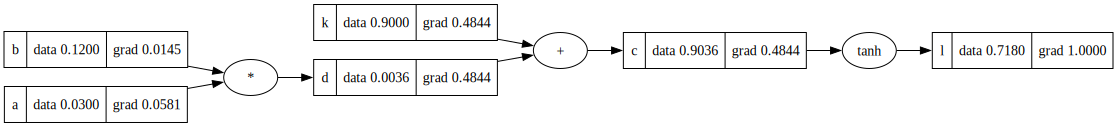

In [6]:
l.grad = 1.0
l.backward()
draw_dot(l)

In [7]:
a + 2
2+ a

Value(data=2.03)

In [8]:
#trying to build the same thing with pytorch 
import torch 
import random

In [9]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True

x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad. item ( ))
print('w2', w2. grad. item ( ))
print('x1', x1. grad. item ( ))
print( 'w1', w1.grad. item ( ))

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
#creating the neuron class

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((xi * wi for xi, wi in zip(x, self.w)), self.b) #starts at b and sums the other elements 
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [11]:
#creating the layer class 

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neroun in self.neurons for p in neroun.parameters()]

In [12]:
#Creating the MLP Multi Layer Preceptor 

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
#defining an example
n = MLP(3, [3, 3, 1])

xs = [
[2.0, 3.0, -1.0],
[3.0, -1.0, 0.5],
[0.5, 1.0, 1.0],
[1.0, 1.0, -1.0]]
ys = [1.0, -.80, -.9650, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9211944666941672),
 Value(data=-0.967028593086154),
 Value(data=-0.34205002602920614),
 Value(data=-0.9674439813960314)]

In [14]:
#Defining a simple square loss function 
loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ys, ypred))
loss

Value(data=7.977789219766306)

In [15]:
loss.backward()

In [16]:

for p in n.parameters():
    p.data += -0.0001 * p.grad

In [17]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ys, ypred))
loss

Value(data=7.976851708472728)

In [30]:
#gradient descend 
for _ in range(100000):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters(): 
        p.data += -0.05 * p.grad
    
    print(loss)

Value(data=2.9314137152532966e-06)
Value(data=2.931386770422807e-06)
Value(data=2.931359826086919e-06)
Value(data=2.931332882246123e-06)
Value(data=2.931305938900459e-06)
Value(data=2.9312789960493395e-06)
Value(data=2.9312520536930536e-06)
Value(data=2.931225111831878e-06)
Value(data=2.931198170465773e-06)
Value(data=2.9311712295939485e-06)
Value(data=2.931144289217216e-06)
Value(data=2.9311173493350057e-06)
Value(data=2.931090409947881e-06)
Value(data=2.931063471055549e-06)
Value(data=2.931036532657723e-06)
Value(data=2.931009594754966e-06)
Value(data=2.930982657346703e-06)
Value(data=2.9309557204329624e-06)
Value(data=2.9309287840142433e-06)
Value(data=2.930901848090037e-06)
Value(data=2.930874912660588e-06)
Value(data=2.9308479777258927e-06)
Value(data=2.930821043285661e-06)
Value(data=2.930794109340175e-06)
Value(data=2.930767175889461e-06)
Value(data=2.930740242933159e-06)
Value(data=2.9307133104716203e-06)
Value(data=2.9306863785042684e-06)
Value(data=2.930659447031884e-06)
Valu

In [29]:
ypred, ys

([Value(data=0.9988682699953527),
  Value(data=-0.7999984958554028),
  Value(data=-0.9649950690839884),
  Value(data=0.9987152427152274)],
 [1.0, -0.8, -0.965, 1.0])